In [1]:
import sys

sys.path.append('../xor_neuron')

In [2]:
%matplotlib inline
# produce vector inline graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'matplotlib'

In [3]:
import pickle
from glob import glob
import os
import yaml
from easydict import EasyDict as edict
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import gridspec as gs
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from foolbox import PyTorchModel, accuracy
from foolbox.attacks import LinfPGD, FGM, FGSM, L2PGD, PGD
import foolbox as fb
import torch.nn as nn
import torch.utils.data
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

In [75]:
dirs = glob('../exp/2D_ARG/MLP/MNIST/*/*_attack_results2.p')
dirs.sort(key=os.path.abspath)
dirs

['../exp/2D_ARG/MLP/MNIST/ComplexNeuronMLP_00_mnist_1057/Auto_attack_results2.p',
 '../exp/2D_ARG/MLP/MNIST/ComplexNeuronMLP_01_mnist_1818/Auto_attack_results2.p',
 '../exp/2D_ARG/MLP/MNIST/ComplexNeuronMLP_02_mnist_0030/Auto_attack_results2.p',
 '../exp/2D_ARG/MLP/MNIST/ComplexNeuronMLP_03_mnist_0635/Auto_attack_results2.p',
 '../exp/2D_ARG/MLP/MNIST/ComplexNeuronMLP_04_mnist_1057/Auto_attack_results2.p',
 '../exp/2D_ARG/MLP/MNIST/ComplexNeuronMLP_05_mnist_1843/Auto_attack_results2.p',
 '../exp/2D_ARG/MLP/MNIST/ComplexNeuronMLP_06_mnist_0116/Auto_attack_results2.p',
 '../exp/2D_ARG/MLP/MNIST/ComplexNeuronMLP_07_mnist_0749/Auto_attack_results2.p',
 '../exp/2D_ARG/MLP/MNIST/ComplexNeuronMLP_08_mnist_1057/Auto_attack_results2.p',
 '../exp/2D_ARG/MLP/MNIST/ComplexNeuronMLP_09_mnist_1833/Auto_attack_results2.p',
 '../exp/2D_ARG/MLP/MNIST/ComplexNeuronMLP_10_mnist_0053/Auto_attack_results2.p',
 '../exp/2D_ARG/MLP/MNIST/ComplexNeuronMLP_11_mnist_0717/Auto_attack_results2.p']

In [76]:
dirs2 = glob('../exp/2D_ARG/Conv/MNIST/*/*_attack_results2.p')
dirs2.sort(key=os.path.abspath)
dirs2

['../exp/2D_ARG/Conv/MNIST/ComplexNeuronConv_00_mnist_1107/Auto_attack_results2.p',
 '../exp/2D_ARG/Conv/MNIST/ComplexNeuronConv_01_mnist_0615/Auto_attack_results2.p',
 '../exp/2D_ARG/Conv/MNIST/ComplexNeuronConv_02_mnist_0503/Auto_attack_results2.p',
 '../exp/2D_ARG/Conv/MNIST/ComplexNeuronConv_03_mnist_0121/Auto_attack_results2.p',
 '../exp/2D_ARG/Conv/MNIST/ComplexNeuronConv_04_mnist_0615/Auto_attack_results2.p',
 '../exp/2D_ARG/Conv/MNIST/ComplexNeuronConv_05_mnist_0513/Auto_attack_results2.p',
 '../exp/2D_ARG/Conv/MNIST/ComplexNeuronConv_06_mnist_0151/Auto_attack_results2.p',
 '../exp/2D_ARG/Conv/MNIST/ComplexNeuronConv_07_mnist_0615/Auto_attack_results2.p',
 '../exp/2D_ARG/Conv/MNIST/ComplexNeuronConv_08_mnist_0515/Auto_attack_results2.p',
 '../exp/2D_ARG/Conv/MNIST/ComplexNeuronConv_09_mnist_0155/Auto_attack_results2.p',
 '../exp/2D_ARG/Conv/MNIST/ComplexNeuronConv_10_mnist_0615/Auto_attack_results2.p',
 '../exp/2D_ARG/Conv/MNIST/ComplexNeuronConv_11_mnist_0458/Auto_attack_resul

In [ ]:
control_dirs = glob('../exp/MLP_Control_Model/CIFAR10/*/*_attack_results.p')
control_dirs.sort(key=os.path.abspath)
control_dirs

In [ ]:
attack = ['FGSM', 'LinfDeepFoolAttack', 'LinfPGD']
color = ['r', 'b', 'g']

In [ ]:
epsilons = [0.0,
 0.001,
 0.002,
 0.003,
 0.01,
 0.1,
 0.2,
 0.3,
 0.4,
 0.5,
 0.6,
 0.7,
 0.8,
 0.9,
 1.0]

In [ ]:
xorNeuron_Acc = {}
xorNeuron_Std = {}

Control_Acc = {}
Control_Std = {}

arg_1D_Acc = {}
arg_1D_Std = {}

for ii in range(len(attack)):    
    xorNeuron_avg_acc = list(np.zeros(len(epsilons)))
    control_avg_acc = list(np.zeros(len(epsilons)))
    arg_1D_avg_acc = list(np.zeros(len(epsilons)))
    
    std_xor = []
    std_control = []
    std_1D = []
    
    idx = ii
    for _ in range(4):
        result = pickle.load(open(dirs[idx], 'rb'))
        epsilons = result['epsilons']

        std_xor.append(result['robust_acc'])
        xorNeuron_avg_acc += result['robust_acc'].numpy()
        
        result_control = pickle.load(open(control_dirs[idx], 'rb'))
        
        std_control.append((result_control['robust_acc']))
        control_avg_acc += result_control['robust_acc'].numpy()
        
        result_1D = pickle.load(open(dirs_1D[idx], 'rb'))
        
        std_1D.append((result_1D['robust_acc']))
        arg_1D_avg_acc += result_1D['robust_acc'].numpy()
        
        idx += len(attack)
        
    xorNeuron_avg = xorNeuron_avg_acc / 4 * 100 
    control_avg = control_avg_acc / 4 * 100
    arg_1D_avg = arg_1D_avg_acc / 4 * 100

    std_xor_neuron = torch.stack([std_xor[0], std_xor[1], std_xor[2], std_xor[3]])
    std_control_model = torch.stack([std_control[0], std_control[1], std_control[2], std_control[3]])
    std_arg_1D = torch.stack([std_1D[0], std_1D[1], std_1D[2], std_1D[3]])

    std_xor_neuron = torch.std(std_xor_neuron, dim=0).numpy()
    std_control_model = torch.std(std_control_model, dim=0).numpy()
    std_arg_1D = torch.std(std_arg_1D, dim=0).numpy()
        
    xorNeuron_Acc[attack[ii]] = list(xorNeuron_avg)
    Control_Acc[attack[ii]] = list(control_avg)
    arg_1D_Acc[attack[ii]] = list(arg_1D_avg)
    
    xorNeuron_Std[attack[ii]] = list(std_xor_neuron/2)
    Control_Std[attack[ii]] = list(std_control_model/2)
    arg_1D_Std[attack[ii]] = list(std_arg_1D/2)

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))

legend_elements = [Line2D([0], [0], lw=1.8, color='k', label='2D arg Xor_Neuron', markerfacecolor='k'),
                   Line2D([0], [0], lw=1.8, color='k', label='1D arg Xor_Neuron', markerfacecolor='k', linestyle='dashdot'),
                   Line2D([0], [0], lw=1.8, color='k', label='Control Model', markerfacecolor='k', linestyle='dashed'),
                   Line2D([0], [0], color=color[0], lw=2.8, label=attack[0]),
                   Line2D([0], [0], color=color[1], lw=2.8, label=attack[1]),
                   Line2D([0], [0], color=color[2], lw=2.8, label=attack[2])]

for ii, adv_attack in enumerate(attack):
    ax.errorbar(epsilons, xorNeuron_Acc[adv_attack], yerr=xorNeuron_Std[adv_attack], capsize=5, color=color[ii])
    ax.errorbar(epsilons, Control_Acc[adv_attack], yerr=Control_Std[adv_attack], capsize=5,  color=color[ii], linestyle='dashed')
    ax.errorbar(epsilons, arg_1D_Acc[adv_attack], yerr=arg_1D_Std[adv_attack], capsize=5,  color=color[ii], linestyle='dashdot')
    
#     ax.scatter(epsilons, xorNeuron_Acc[adv_attack], marker='o', s=60, color=color[ii])
#     ax.scatter(epsilons, Control_Acc[adv_attack], marker='^', s=60, color=color[ii])
    
    ax.set_title("Adversarial Attack\nMLP CIFAR10", fontsize=27)
    ax.set_xlabel('Epsilon', fontsize=16)
    ax.set_ylabel('Accuracy(%)', fontsize=16)
#     ax.set_ylim([0,0.7])

ax.grid(True)    
ax.legend(handles=legend_elements, loc='upper right', fontsize=14)

# plt.savefig("./Adversarial_Attack_MLP_CIFAR10.pdf")
fig.show()

In [ ]:
attack = ["Boundary Attack", "EAD Attack", 'FGSM', 'L2CarliniWagner Attack', 'LinfDeepFool Attack', 'LinfPGD']

In [ ]:
for ii in range(6):
    idx = ii
    result = pickle.load(open(dirs[idx], 'rb'))
    epsilons = result['epsilons']

    f, axes = plt.subplots(nrows=len(epsilons) // 2, ncols=5, figsize=(20,50), constrained_layout=True)

    for row in range(len(epsilons)//2):
        eps = row * 2
        x = result['adv_img'][eps].numpy()
        x = np.transpose(x,   axes=(0,2,3,1))
        for col in range(5):
            ax = axes[row][col]
            ax.set_xticks([])
            ax.set_yticks([])
            if col == 2:
                ax.set_title(f"Epsilon = {epsilons[eps]}", fontsize = 60)
            ax.axis("off")      
            ax.imshow(x[col])
            
    f.suptitle(f'{attack[ii]}',fontweight ="bold", fontsize = 30)
#     f.savefig(f"./{attack[ii]}")

## Auto Attack

In [ ]:
eps = [0.031, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9, 1]

In [ ]:
exp_dirs = [['../exp/xor_neuron_mlp_mnist/*/Auto_attack_results2.p', 
             '../exp/MLP_Control_Model/MNIST/*/Auto_attack_results2.p'],
            ['../exp/xor_neuron_mlp_cifar/*/Auto_attack_results2.p', 
             '../exp/MLP_Control_Model/CIFAR10/*/Auto_attack_results2.p'],
            ['../exp/xor_neuron_conv_mnist/*/Auto_attack_results2.p', 
             '../exp/Conv_Control_Model/MNIST/*/Auto_attack_results2.p'],
            ['../exp/xor_neuron_conv_cifar/*/Auto_attack_results2.p', 
             '../exp/Conv_Control_Model/CIFAR10/*/Auto_attack_results2.p']]

In [ ]:
dirs = glob('../exp/xor_neuron_mlp_cifar/*/Auto_attack_results2.p')[0]
result_xor = pickle.load(open(dirs, 'rb'))

dirs_control = glob('../exp/MLP_Control_Model/CIFAR10/*/Auto_attack_results2.p')[0]
result_control = pickle.load(open(dirs_control, 'rb'))

In [ ]:
dirs = glob(exp_dirs[2][0])

In [ ]:
dirs

In [ ]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(8,25))

model_dataset = ['MLP MNIST', 'MLP CIFAR10', 'Conv MNIST', 'Conv CIFAR10']
for ii, exp in enumerate(exp_dirs):
    dirs = glob(exp[0])[0]
    result_xor = pickle.load(open(dirs, 'rb'))
    xor_acc = np.array(result_xor['robust_acc']) * 100

    dirs_control = glob(exp[1])[0]
    result_control = pickle.load(open(dirs_control, 'rb'))
    control_acc = np.array(result_control['robust_acc']) * 100
    
    legend_elements = [Line2D([0], [0], lw=1, color='k', label='2D arg Xor_Neuron', markerfacecolor='k'),
                       Line2D([0], [0], lw=1, color='k', label='Control Model', markerfacecolor='k', linestyle='dashed')]

    ax[ii].plot(eps, xor_acc, color='k', label='2D arg Xor_Neuron')
    ax[ii].plot(eps, control_acc, color='k', label='Control Model', linestyle='dashed')

    ax[ii].set_title(f"\n{model_dataset[ii]}", fontsize=10)
    ax[ii].set_xlabel('Epsilon')
    ax[ii].set_ylabel('Accuracy(%)')

    ax[ii].grid(True)    
    ax[ii].legend(handles=legend_elements)
    
f.savefig("./Auto_attack_robustness.pdf")

## AutoAttack mean_std

In [77]:
dirs

['../exp/2D_ARG/MLP/MNIST/ComplexNeuronMLP_00_mnist_1057/Auto_attack_results2.p',
 '../exp/2D_ARG/MLP/MNIST/ComplexNeuronMLP_01_mnist_1818/Auto_attack_results2.p',
 '../exp/2D_ARG/MLP/MNIST/ComplexNeuronMLP_02_mnist_0030/Auto_attack_results2.p',
 '../exp/2D_ARG/MLP/MNIST/ComplexNeuronMLP_03_mnist_0635/Auto_attack_results2.p',
 '../exp/2D_ARG/MLP/MNIST/ComplexNeuronMLP_04_mnist_1057/Auto_attack_results2.p',
 '../exp/2D_ARG/MLP/MNIST/ComplexNeuronMLP_05_mnist_1843/Auto_attack_results2.p',
 '../exp/2D_ARG/MLP/MNIST/ComplexNeuronMLP_06_mnist_0116/Auto_attack_results2.p',
 '../exp/2D_ARG/MLP/MNIST/ComplexNeuronMLP_07_mnist_0749/Auto_attack_results2.p',
 '../exp/2D_ARG/MLP/MNIST/ComplexNeuronMLP_08_mnist_1057/Auto_attack_results2.p',
 '../exp/2D_ARG/MLP/MNIST/ComplexNeuronMLP_09_mnist_1833/Auto_attack_results2.p',
 '../exp/2D_ARG/MLP/MNIST/ComplexNeuronMLP_10_mnist_0053/Auto_attack_results2.p',
 '../exp/2D_ARG/MLP/MNIST/ComplexNeuronMLP_11_mnist_0717/Auto_attack_results2.p']

In [78]:
dirs2

['../exp/2D_ARG/Conv/MNIST/ComplexNeuronConv_00_mnist_1107/Auto_attack_results2.p',
 '../exp/2D_ARG/Conv/MNIST/ComplexNeuronConv_01_mnist_0615/Auto_attack_results2.p',
 '../exp/2D_ARG/Conv/MNIST/ComplexNeuronConv_02_mnist_0503/Auto_attack_results2.p',
 '../exp/2D_ARG/Conv/MNIST/ComplexNeuronConv_03_mnist_0121/Auto_attack_results2.p',
 '../exp/2D_ARG/Conv/MNIST/ComplexNeuronConv_04_mnist_0615/Auto_attack_results2.p',
 '../exp/2D_ARG/Conv/MNIST/ComplexNeuronConv_05_mnist_0513/Auto_attack_results2.p',
 '../exp/2D_ARG/Conv/MNIST/ComplexNeuronConv_06_mnist_0151/Auto_attack_results2.p',
 '../exp/2D_ARG/Conv/MNIST/ComplexNeuronConv_07_mnist_0615/Auto_attack_results2.p',
 '../exp/2D_ARG/Conv/MNIST/ComplexNeuronConv_08_mnist_0515/Auto_attack_results2.p',
 '../exp/2D_ARG/Conv/MNIST/ComplexNeuronConv_09_mnist_0155/Auto_attack_results2.p',
 '../exp/2D_ARG/Conv/MNIST/ComplexNeuronConv_10_mnist_0615/Auto_attack_results2.p',
 '../exp/2D_ARG/Conv/MNIST/ComplexNeuronConv_11_mnist_0458/Auto_attack_resul

In [81]:
eps = [0.031, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9, 1]
len(eps)

9

In [82]:
def get_mean_std(dirs):
    robust_std = []
    robust_acc = np.zeros(9)
    
    for dr in dirs:
        result_xor = pickle.load(open(dr, 'rb'))
        robust_std.append(result_xor['robust_acc'])
        robust_acc += np.array(result_xor['robust_acc'])
    
    avg_acc = robust_acc / len(dirs) * 100
    robust_std = np.array(robust_std)
    std = []
    for i in range(len(robust_std.T)):
        std.append(np.std(robust_std.T[i]))
    std = np.array(std) * 100 / 2
    
    return avg_acc, std

In [83]:
acc, std = get_mean_std(dirs)

In [84]:
acc2, std2 = get_mean_std(dirs2)

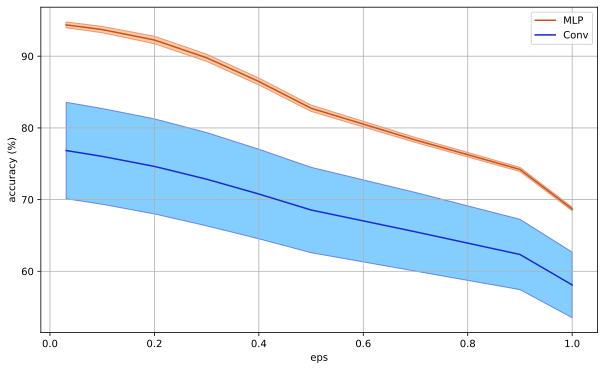

In [88]:
f, ax = plt.subplots(figsize=(10,6))

ax.plot(eps, acc, color='#CC4F1B', label="MLP")
ax.fill_between(eps, acc+std, 
                acc-std, 
                alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')

ax.plot(eps, acc2, color='#1B2ACC', label="Conv")
ax.fill_between(eps, acc2+std2, 
                acc2-std2, 
                alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')

ax.set_xlabel('eps')
ax.set_ylabel('accuracy (%)')

ax.grid(True)
ax.legend()

f.savefig('./autoattack.pdf')